*Technical University of Munich<br>
Professorship of Environmental Sensing and Modeling<br><br>*
**Author:**  Daniel Kühbacher<br>
**Date:**  30.08.2024

--- 

# Optimize volume-capacity thresholds

<!--Notebook description and usage information-->
As road link capacities in traffic models are often adjusted during calibration, vc-thresholds cannot be universally applied and must be carefully reviewed for each specific application. Furthermore, in urban areas, traffic flow is more often limited by the capacity of intersections than by the road links between them. Intersections, where traffic merges and is controlled, tend to create bottlenecks, making them the main factor in determining the traffic condition. Finally, errors can occur when exporting the results of traffic models. For instance, the capacity may refer to both directions combined, but the export shows two separate links, each of which was incorrectly assigned the total capacity. Therefore, it is inevitable to validate and optimize the vc-thresholds applied.



In [5]:
# this function was exported to allow multiprocessing.
import sys

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime

plt.style.use('seaborn-v0_8-paper')

from itertools import chain

sys.path.append('../utils')
import data_paths
from traffic_counts import TrafficCounts
from hbefa_hot_emissions import HbefaHotEmissions

# Notebook Settings

In [34]:
# Define start and end time for emission calculation. Ideally this should cover a whole year.
start_date = datetime(2019, 1, 1)
end_date = datetime(2019, 12, 31)

# define filename of the visum file
visum_filename = "visum_links.GPKG"

# if True, the script will only calculate the emission for the area within the roi polygon
clip_to_area = True 
roi_polygon = data_paths.MUNICH_BOARDERS_FILE # defines ROI for clipping

# define which road type to optimize for
optimize_road_type = 'Motorway-Nat'

# define hbefa service thresholds
service_thresholds = {'Motorway-Nat': [0.5, 0.71, 0.98, 1.1],
                    'Motorway-City': [0.5, 0.71, 0.98, 1.1], # not used
                    'TrunkRoad/Primary-National': [0.33, 0.5, 0.7, 0.8],
                    'TrunkRoad/Primary-City': [0.67, 0.82, 0.92, 1.02],
                    'Distributor/Secondary': [0.37, 0.5, 0.63, 0.8],
                    'Local/Collector': [0.55, 0.75, 0.9, 1], # not used
                    'Access-residential': [0.14, 0.25, 0.39, 0.52]}

## Import data

In [35]:
# import visum model
visum = gpd.read_file(data_paths.VISUM_FOLDER_PATH + visum_filename)

if clip_to_area:
    roi = gpd.read_file(roi_polygon).to_crs(visum.crs)
    visum = gpd.clip(visum, roi)
    visum = visum.explode(ignore_index=True) # convert multipolygons to polygons

#visum = visum_links
visum = visum.reset_index(drop = True).reset_index() # reset index for calculation
visum['road_lenght'] = visum['geometry'].length # add road length to visum dict

# initialize traffic cycles
cycles = TrafficCounts(init_timeprofile=False)

# initialize HBEFA emission factors
hbefa = HbefaHotEmissions()

# apply service thresholds as defined in the notebook setting
hbefa.service_thresholds = service_thresholds

Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_PC.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_LCV.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_HGV.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_Coach.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_MOT.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/ef_aggregated_los/EFA_HOT_Vehcat

## Notebook functions

In [36]:
def process_veh_kilometers (date: str,
                            visum_dict:dict,
                            cycles_obj:TrafficCounts,
                            hbefa_obj:HbefaHotEmissions,
                            ) -> bool:
    """Function to calculate daily emissions for a given date. 
    This implements the HbefaHotEmissions object and can be run as parallell processes.

    Args:
        date (str): day to be calculated
        visum_dict (dict): traffic model as dict for faster looping
        cycles_obj (TrafficCounts): object to access traffic cycles
        hbefa_obj (HbefaHotEmissions): object to access emission factors
    Returns:
        bool: true if process finished without error, false if not.
    """
    # get scaling factors for the day
    diurnal_cycles = cycles_obj.get_hourly_scaling_factors(date= date)
    vehicle_shares = cycles_obj.get_vehicle_share(date= date).to_dict()
    daily_scaling = cycles_obj.get_daily_scaling_factors(date= date).to_dict()
    
    # initialize result variables
    result = list()
    final_result = {'Freeflow': np.array(5, float),
                    'Heavy': np.array(5, float),
                    'Satur.': np.array(5, float),
                    'St+Go': np.array(5, float),
                    'St+Go2': np.array(5, float)}
    
    # loop over visum model
    for row in visum_dict:
        
        # relevant information from the visum model
        dtv_visum = row['dtv_SUM']
        hgv_corr = row['hgv_corr']
        lcv_corr = row['lcv_corr']
        scaling_road_type = row['scaling_road_type']
        
        # get vehicle shares from counting data
        hgv_share = vehicle_shares['HGV'][scaling_road_type]
        lcv_share = vehicle_shares['LCV'][scaling_road_type]
        pc_share = vehicle_shares['PC'][scaling_road_type]
        mot_share = vehicle_shares['MOT'][scaling_road_type]
        bus_share = vehicle_shares['BUS'][scaling_road_type]
        
        # calculate vehicle share correction factor
        k = (1- (hgv_corr * hgv_share)- (lcv_corr * lcv_share)) / (1 - hgv_share - lcv_share)
        
        # calculate vehicle counts
        dtv = dict()
        dtv_day = dtv_visum * daily_scaling[scaling_road_type] # daily traffic volume
        dtv.update({'HGV' : (dtv_day * hgv_share * hgv_corr)})
        dtv.update({'LCV' : (dtv_day * lcv_share * lcv_corr)})
        dtv.update({'PC' : (dtv_day * pc_share * k)})
        dtv.update({'MOT' : (dtv_day * mot_share * k)})
        dtv.update({'BUS' : (dtv_day * bus_share * k)})
        
        # disaggregate daily traffic to hourly traffic for each vehicle class
        dtv_array = np.array([dtv[v] for v in diurnal_cycles.index])
        htv = (np.transpose(diurnal_cycles.to_numpy()) * dtv_array)
        
        # convert hourly traffic volume to personal car equivalents
        htv_car_units = np.array([HbefaHotEmissions.car_unit_factors[v]\
            for v in diurnal_cycles.index])
        htv_car_units = (htv * htv_car_units).sum(axis=1)
        
        # list of 24 service classes for each hour of the day
        los_class = [hbefa_obj.calc_los_class(htv_car_unit = x,
                                                hour_capacity = row['hour_capacity'],
                                                road_type = row['road_type'],
                                                hbefa_speed = row['hbefa_speed'])
                        for x in htv_car_units]
        los =  [x.split('/')[-1] for x in los_class]

        # now calculate vehicle kilometers
        veh_kilometers  = htv * row['road_lenght'] *1e-3 # in km

        # zip los class and vehicle kilometers and append to result list
        result.append(list(zip(los, veh_kilometers)))
    
    # sum up the results
    for e in list(chain(*result)):
        final_result[e[0]] = final_result[e[0]] + e[1]
    
    return final_result, diurnal_cycles.index

## Calculate VKT for each vehicle class and traffic condition

In [37]:
# reduce the visum model to the road type of interest
visum_mw = visum[visum['road_type'] == optimize_road_type]#.sample(3000)

# generate dates index
dates = [d.strftime("%Y-%m-%d") for d in pd.date_range(start=start_date,
                                                       end=end_date, freq='1d')]

final_result = {'Freeflow': np.array(5, float),
                'Heavy': np.array(5, float),
                'Satur.': np.array(5, float),
                'St+Go': np.array(5, float),
                'St+Go2': np.array(5, float)}
for date in dates:
    cl, vehicle_index = process_veh_kilometers(date = date,
                        visum_dict = visum_mw.to_dict('records'),
                        cycles_obj = cycles,
                        hbefa_obj = hbefa)

    for key, value in cl.items():
        final_result[key] = final_result[key] + value

# convert results to dataframe
result_df = pd.DataFrame(final_result, index = vehicle_index)

/var/folders/5v/yv2xq6j56r5459_qjzrm79rw0000gn/T/ipykernel_24430/13659055.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels = y_labels, fontsize= 10)


AttributeError: 'Series' object has no attribute 'iterrows'

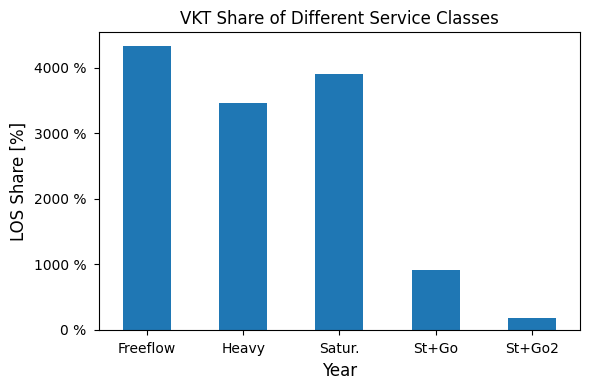

In [40]:
# calculate the share of vkt for each level of service
total_vkt = result_df.loc['PC'].sum().sum()
vkt_share = (result_df.sum() / total_vkt)*100

fig, ax = plt.subplots(figsize =(6,4), tight_layout =True)

vkt_share.plot(ax = ax, kind='bar', stacked = True)

plt.title('VKT Share of Different Service Classes', fontsize = 12)


y_labels = ax.get_yticks()
y_labels = [f'{label*1e2:.0f} %' for label in y_labels]
ax.set_xticklabels(labels = ax.get_xticklabels(), rotation=0, fontsize = 10)
ax.set_yticklabels(labels = y_labels, fontsize= 10)
ax.set_ylabel('LOS Share [%]', fontsize = 12)
ax.set_xlabel('Year', fontsize = 12)

iterator = 0
for idx, row in vkt_share.iterrows():
    pos_y = 0
    for el in row:
        ax.text(y = pos_y +(el/2),
            x= iterator,
            s = f'{el*100:.0f}%',
            fontsize = 8,
            ha = 'center',
            va = 'center', color = 'black')
        if (el)<0.05:
            pos_y += (el + 0.03)
        else:
            pos_y += el
    iterator+=1

plt.legend(bbox_to_anchor =(1.2,0), loc = 'lower center', ncols=1, fontsize = 10)
plt.show()